In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
df = pd.read_csv('reshaped_data.csv')

In [14]:
df.head()

,dataset,trial_number,time,eeg1,eeg10,eeg11,eeg12,eeg13,eeg14,eeg15,...,eeg8,eeg9,emg1,emg2,emg3,emg4,emg5,emg6,emg7,emg8
0,Bicep_10_Trials_April30,1,0.0,9835.647448,109928.896063,30784.974972,-13964.630094,-13384.606660,21214.022232,66387.861774,...,5762.684623,7983.357305,-2.000000,-2.000000,-2.0,-1.000000,-3.000000,2.000000,1.000000,-1.000000
1,Bicep_10_Trials_April30,1,1.0,9847.503804,108942.571556,30791.993921,-13967.106857,-13377.363261,21213.218577,65456.253098,...,5772.355710,7955.293758,1.000000,1.000000,-3.0,2.000000,0.000000,-1.000000,-2.000000,2.000000
2,Bicep_10_Trials_April30,1,17.0,9836.453661,108593.653923,30791.196313,-13958.783430,-13387.701152,21211.019848,65228.703139,...,5766.450417,7961.680007,0.304098,-1.087706,-3.0,-1.479509,-0.695902,0.391804,-0.608196,1.304098
3,Bicep_10_Trials_April30,1,19.0,9824.251330,109306.808926,30786.973279,-13955.309772,-13400.436936,21214.029282,65930.455630,...,5749.945614,7992.207312,0.217132,-1.348603,-3.0,-1.914339,-0.782868,0.565736,-0.434264,1.217132
4,Bicep_10_Trials_April30,1,21.0,9822.452223,110075.749352,30790.422440,-13956.651942,-13406.806874,21210.122659,66565.487089,...,5750.457561,8000.216385,0.130123,-1.609632,-3.0,-2.349387,-0.869877,0.739755,-0.260245,1.130123


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495320 entries, 0 to 495319
Data columns (total 38 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   dataset       495320 non-null  object 
 1   trial_number  495320 non-null  int64  
 2   time          495320 non-null  float64
 3   eeg1          495320 non-null  float64
 4   eeg10         495320 non-null  float64
 5   eeg11         495320 non-null  float64
 6   eeg12         495320 non-null  float64
 7   eeg13         495320 non-null  float64
 8   eeg14         495320 non-null  float64
 9   eeg15         495320 non-null  float64
 10  eeg16         495320 non-null  float64
 11  eeg17         495320 non-null  float64
 12  eeg18         495320 non-null  float64
 13  eeg19         495320 non-null  float64
 14  eeg2          495320 non-null  float64
 15  eeg20         495320 non-null  float64
 16  eeg21         495320 non-null  float64
 17  eeg22         495320 non-null  float64
 18  eeg2

In [16]:
#make the EMG rectified -> then get envelope
for col in df.columns:
    if col.startswith('emg'):
        df[col] = np.abs(df[col])
        # calculate the envelope using a rolling mean
        df[col] = df[col].rolling(window=250, min_periods=2).mean()
    if col.startswith('eeg'):
        #df[col] = np.abs(df[col])
        pass

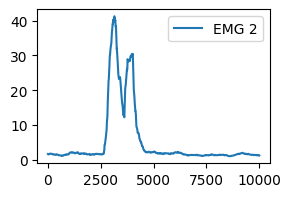

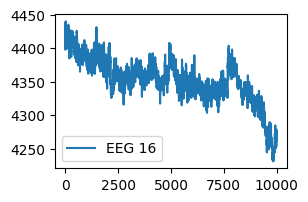

In [17]:
# plot the emg and eeg data
datasubset = df[(df['dataset'] == df['dataset'].iloc[0]) & (df['trial_number'] == 7)]
plt.figure(figsize=(3,2))
plt.plot(datasubset['time'], datasubset['emg2'], label='EMG 2')
plt.legend()

plt.figure(figsize=(3,2))
plt.plot(datasubset['time'], datasubset['eeg16'], label='EEG 16')
plt.legend()

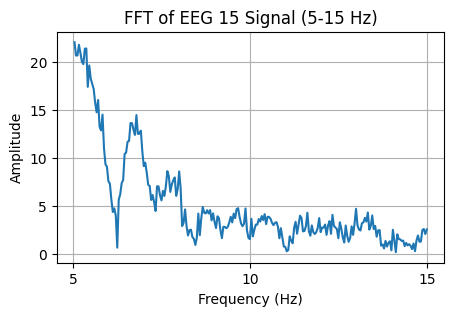

In [27]:
from scipy.fft import fft, fftfreq

def plot_fft(data, fs=1000, min_freq=5, max_freq=15):
    N = len(data)
    T = 1.0 / fs
    yf = fft(data)
    xf = fftfreq(N, T)
    # Only keep frequencies from min_freq to max_freq
    idx = (xf >= min_freq) & (xf <= max_freq)
    plt.figure(figsize=(5, 3))
    plt.plot(xf[idx], 2.0/N * np.abs(yf[idx]))
    plt.title(f'FFT of EEG 15 Signal ({min_freq}-{max_freq} Hz)')
    plt.xlabel('Frequency (Hz)')
    plt.xticks(np.arange(min_freq, max_freq+1, 5))
    plt.ylabel('Amplitude')
    plt.grid()
    plt.show()

plot_fft(datasubset['eeg15'], fs=250, min_freq=5, max_freq=15)

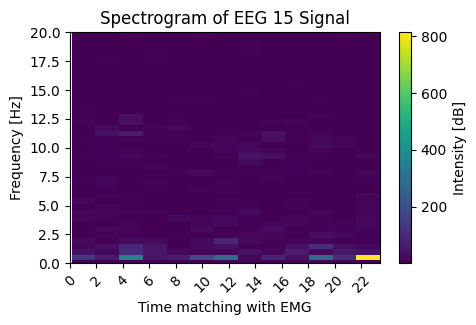

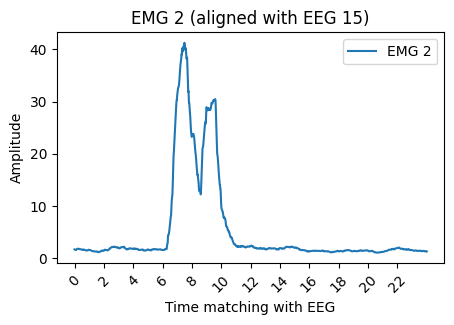

In [31]:
# Draw an STFT of the EEG along with EMG data to see correlation
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

def plot_stft(data, fs=250, nperseg=256):
    f, t, Sxx = spectrogram(data, fs=fs, nperseg=nperseg)
    plt.figure(figsize=(5, 3))
    plt.pcolormesh(t, f, Sxx, shading='auto', cmap='viridis')
    plt.colorbar(label='Intensity [dB]')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time matching with EMG')
    plt.title('Spectrogram of EEG 15 Signal')
    plt.xticks(np.arange(0, 23, 2), rotation=45)
    plt.ylim(0, 20)  # Limit frequency range for better visibility
    plt.show()

# Ensure EEG and EMG are aligned by index (drop NaNs and reset index)
aligned = datasubset[['eeg16', 'emg2']].dropna().reset_index(drop=True)

# Plot STFT for EEG
plot_stft(aligned['eeg16'], fs=250, nperseg=512)

# Plot EMG data on the same time base
plt.figure(figsize=(5,3))
fs = 250
time = np.arange(0, len(aligned['emg2'])) / fs
plt.plot(time, aligned['emg2'], label='EMG 2')
plt.xlabel('Time matching with EEG')
plt.xticks(np.arange(0, 23, 2), rotation=45)
plt.ylabel('Amplitude')
plt.legend()
plt.title('EMG 2 (aligned with EEG 15)')
plt.show()

In [22]:
def extract_features(df):
    features = {}
    features['mean_eeg19'] = df['eeg19'].mean()
    features['std_eeg19'] = df['eeg19'].std()
    features['max_eeg19'] = df['eeg19'].max()
    features['min_eeg19'] = df['eeg19'].min()
    
    features['mean_emg2'] = df['emg2'].mean()
    features['std_emg2'] = df['emg2'].std()
    features['max_emg2'] = df['emg2'].max()
    features['min_emg2'] = df['emg2'].min()
    
    return pd.DataFrame([features])

features = extract_features(datasubset)
print(features)

      mean_eeg19    std_eeg19      max_eeg19     min_eeg19  mean_emg2  \
0  114432.915079  8861.341117  166535.274498  55739.472269   5.287772   

   std_emg2   max_emg2  min_emg2  
0  9.018211  41.272021  1.032112  


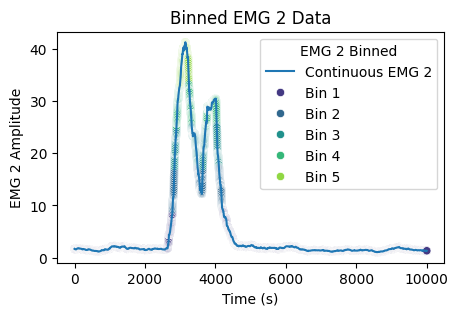

In [23]:
def bin_emg_data(df, column='emg2', bins=5):
    # Create a copy to avoid SettingWithCopyWarning
    df = df.copy()
    bin_edges = np.linspace(df[column].min(), df[column].max(), bins + 1)
    bin_labels = [f'Bin {i+1}' for i in range(bins)]
    df.loc[:, f'{column}_binned'] = pd.cut(df[column], bins=bin_edges, labels=bin_labels, include_lowest=True)
    return df

datasubset = bin_emg_data(datasubset, column='emg2', bins=5)
#visualize the binned EMG data with continuus EMG data
plt.figure(figsize=(5, 3))
sns.lineplot(x='time', y='emg2', data=datasubset, label='Continuous EMG 2')
sns.scatterplot(x='time', y='emg2', hue='emg2_binned', data=datasubset, palette='viridis', legend='full')
plt.xlabel('Time (s)')
plt.ylabel('EMG 2 Amplitude')
plt.title('Binned EMG 2 Data')
plt.legend(title='EMG 2 Binned')
plt.show()

C:\Users\unnat\AppData\Local\Temp\ipykernel_8216\1973805746.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='emg2_binned', data=datasubset, palette='viridis')


([0, 1, 2, 3, 4],
 [Text(0, 0, 'Bin 1'),
  Text(1, 0, 'Bin 2'),
  Text(2, 0, 'Bin 3'),
  Text(3, 0, 'Bin 4'),
  Text(4, 0, 'Bin 5')])

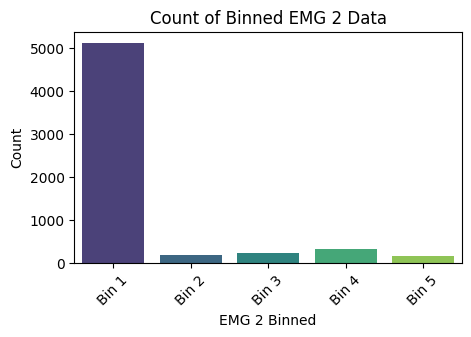

In [24]:
#countplot of binned EMG data
plt.figure(figsize=(5, 3))
sns.countplot(x='emg2_binned', data=datasubset, palette='viridis')
plt.xlabel('EMG 2 Binned')
plt.ylabel('Count')
plt.title('Count of Binned EMG 2 Data')
plt.xticks(rotation=45)